In [1]:
# required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import torch
from torch import nn
from torchmetrics import Accuracy

2023-08-09 18:18:02.179995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 18:18:04.613850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-09 18:18:04.614016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-09 18:18:04.614030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Data Preproccessing

In [2]:
# dataframe customs
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.2f" %x)

In [3]:
# read the data
def get_data():
    df = pd.read_csv("Placement_Data_Full_Class.csv")
    return df

In [4]:
df = get_data()

In [5]:
# quick overview
def check_df(df, line=5):
    print("### HEAD ###")
    print(df.head(line), end="\n\n")
    print("### TAIL ###")
    print(df.tail(line), end="\n\n")
    print("### INFO ###")
    print(df.info(), end="\n\n")
    print("### SHAPE ###")
    print(df.shape, end="\n\n")
    print("### DESCRIBE ###")
    print(df.describe().T, end="\n\n")

In [6]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.00,Mkt&HR,58.80,Placed,270000.00
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.50,Mkt&Fin,66.28,Placed,200000.00
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.00,Mkt&Fin,57.80,Placed,250000.00
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.00,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.80,Mkt&Fin,55.50,Placed,425000.00


In [7]:
df.columns

Index(['sl_no', 'gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s', 'degree_p', 'degree_t', 'workex', 'etest_p', 'specialisation', 'mba_p', 'status', 'salary'], dtype='object')

In [8]:
# renaming columns
df.rename(columns={"sl_no": "sl_no",
                   'gender': "gender", 
                   'ssc_p' : "10th_grade",
                   'ssc_b' : "board_of_edu10", 
                   'hsc_p' :"12nd_grade", 
                   'hsc_b' : "board_of_edu12", 
                   'hsc_s': "higher_edu_field", 
                   'degree_p' :"degree_p", 
                   'degree_t' :"field_of_edu", 
                   'workex' : "workex",
                   'etest_p' :"employability_t", 
                   'specialisation' : "specialisation", 
                   'mba_p' : "mba_p", 
                   'status' :"status", 
                   'salary': "salary"}, inplace=True) 

In [9]:
check_df(df)

### HEAD ###
   sl_no gender  10th_grade board_of_edu10  12nd_grade board_of_edu12 higher_edu_field  degree_p field_of_edu workex  employability_t specialisation  mba_p      status    salary
0      1      M       67.00         Others       91.00         Others         Commerce     58.00     Sci&Tech     No            55.00         Mkt&HR  58.80      Placed 270000.00
1      2      M       79.33        Central       78.33         Others          Science     77.48     Sci&Tech    Yes            86.50        Mkt&Fin  66.28      Placed 200000.00
2      3      M       65.00        Central       68.00        Central             Arts     64.00    Comm&Mgmt     No            75.00        Mkt&Fin  57.80      Placed 250000.00
3      4      M       56.00        Central       52.00        Central          Science     52.00     Sci&Tech     No            66.00         Mkt&HR  59.43  Not Placed       NaN
4      5      M       85.80        Central       73.60        Central         Commerce     73.30 

In [10]:
# droping unnecessary column
df.drop("sl_no", inplace=True, axis=1)

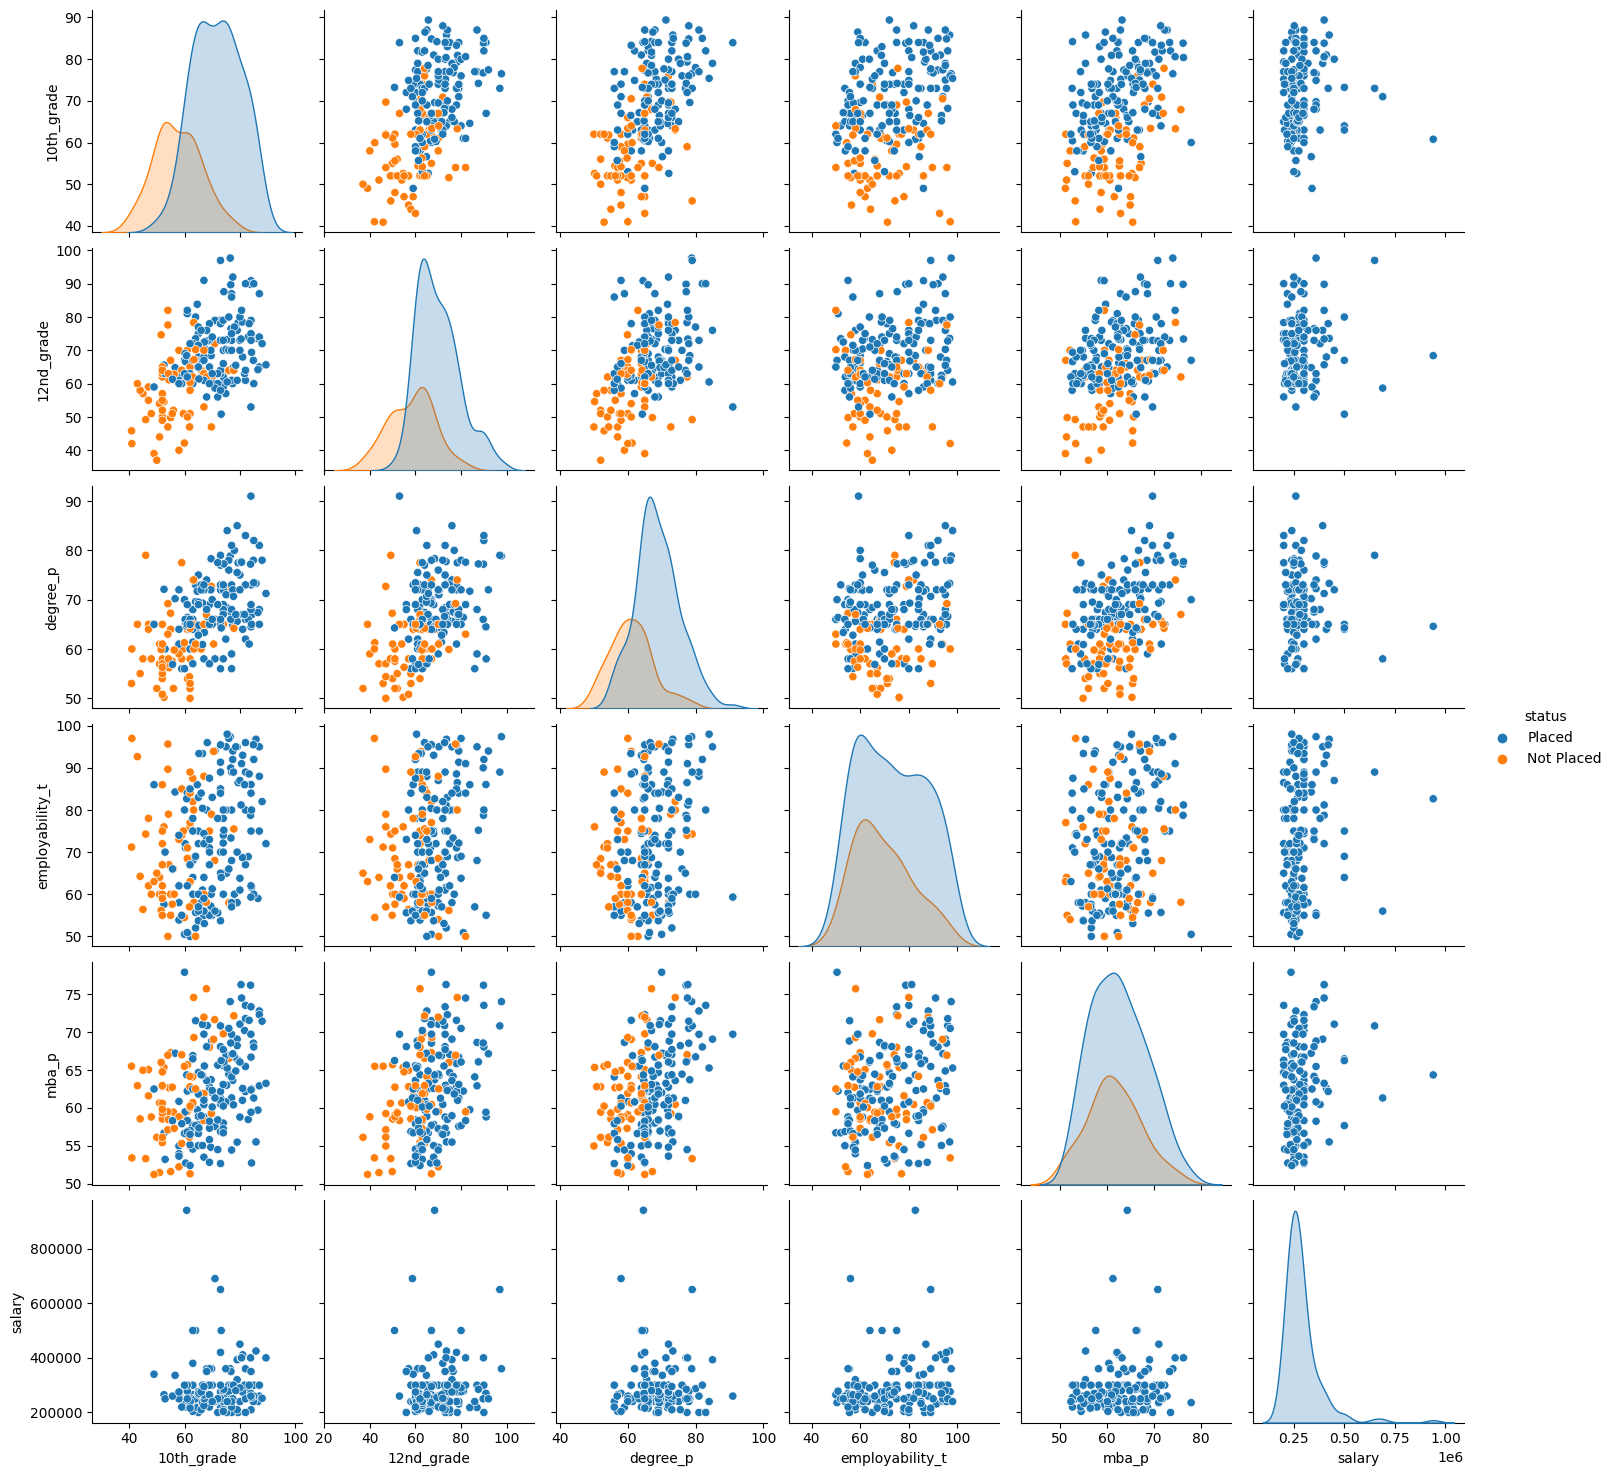

In [11]:
#  scatter plot matrix of numerical variables
sns.pairplot(df, hue="status")
plt.show()

In [12]:
# categorize the columns based on criterias
def grab_col_names(df, cat_th=10, car_th=20): 
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].dtypes != "O" and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations : {df.shape[0]}", end="\n\n")
    print(f"Variables : {df.shape[1]}", end="\n\n")    
    print(f"cat_cols : {cat_cols}", end="\n\n")    
    print(f"num_cols : {num_cols}", end="\n\n")    
    print(f"cat_but_car : {cat_but_car}", end="\n\n")    
    print(f"num_but_car: {num_but_cat}", end="\n\n")    
    
    return cat_cols, num_cols, cat_but_car

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations : 215

Variables : 14

cat_cols : ['gender', 'board_of_edu10', 'board_of_edu12', 'higher_edu_field', 'field_of_edu', 'workex', 'specialisation', 'status']

num_cols : ['10th_grade', '12nd_grade', 'degree_p', 'employability_t', 'mba_p', 'salary']

cat_but_car : []

num_but_car: []



In [14]:
# below function show us summary of categorical variables
def cat_summary(df, col, plot=False):
    print(pd.DataFrame({col : df[col].value_counts(),
                        "Ratio" : 100 * df[col].value_counts() / len(df)}))
    print("###")
    if plot:
        sns.countplot(x=df[col], data=df)
        plt.show()

   gender  Ratio
M     139  64.65
F      76  35.35
###


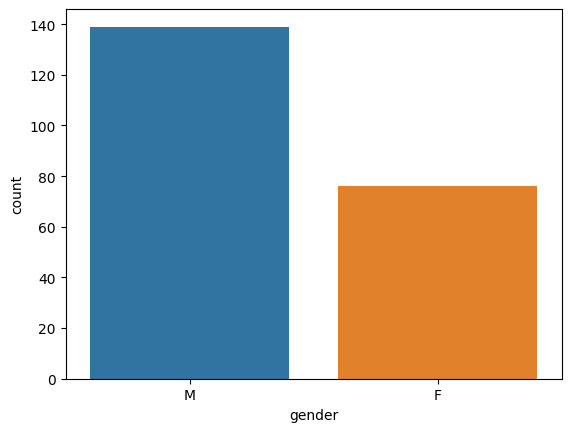

         board_of_edu10  Ratio
Central             116  53.95
Others               99  46.05
###


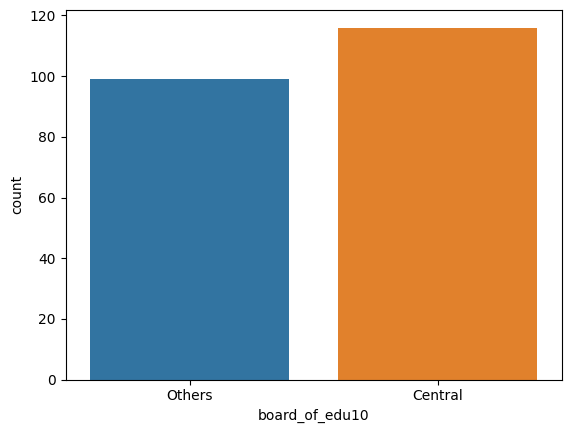

         board_of_edu12  Ratio
Others              131  60.93
Central              84  39.07
###


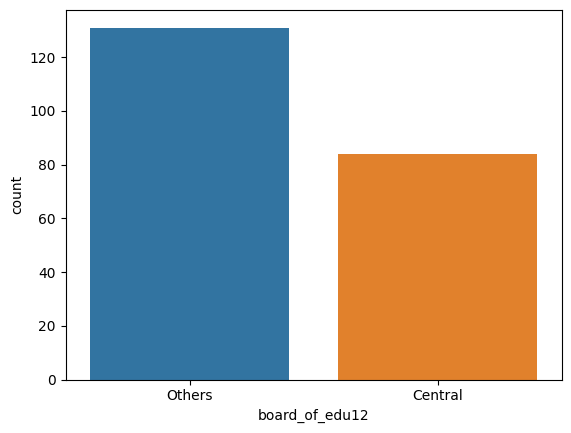

          higher_edu_field  Ratio
Commerce               113  52.56
Science                 91  42.33
Arts                    11   5.12
###


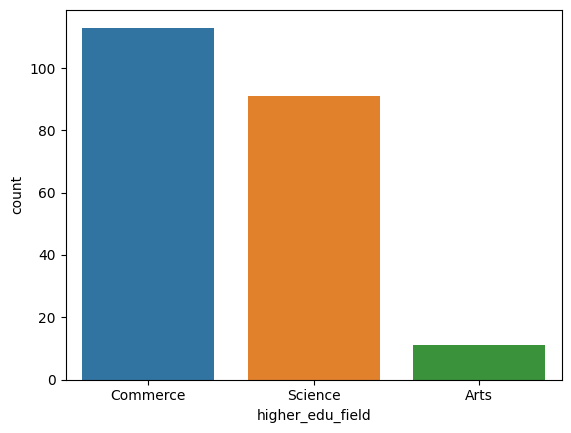

           field_of_edu  Ratio
Comm&Mgmt           145  67.44
Sci&Tech             59  27.44
Others               11   5.12
###


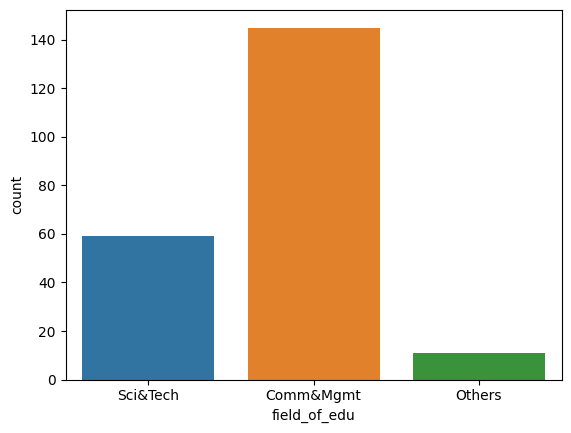

     workex  Ratio
No      141  65.58
Yes      74  34.42
###


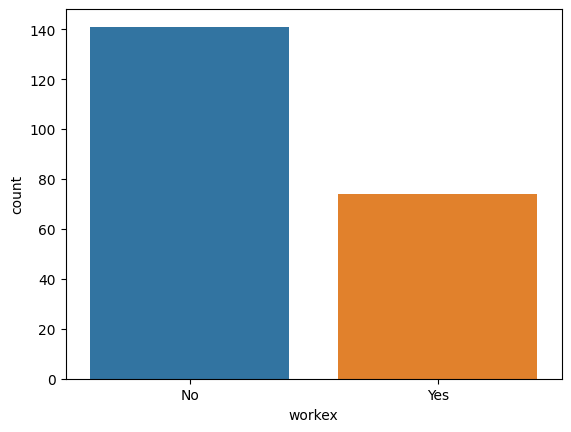

         specialisation  Ratio
Mkt&Fin             120  55.81
Mkt&HR               95  44.19
###


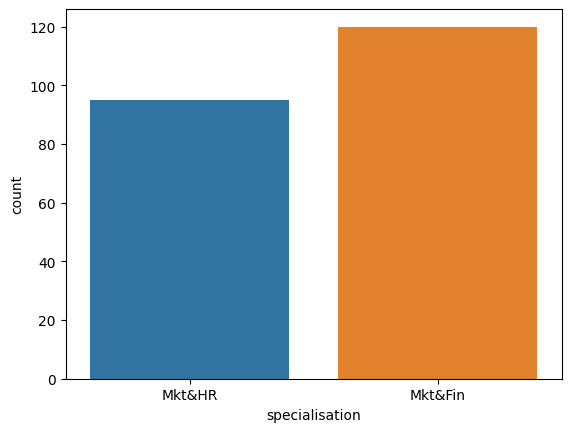

            status  Ratio
Placed         148  68.84
Not Placed      67  31.16
###


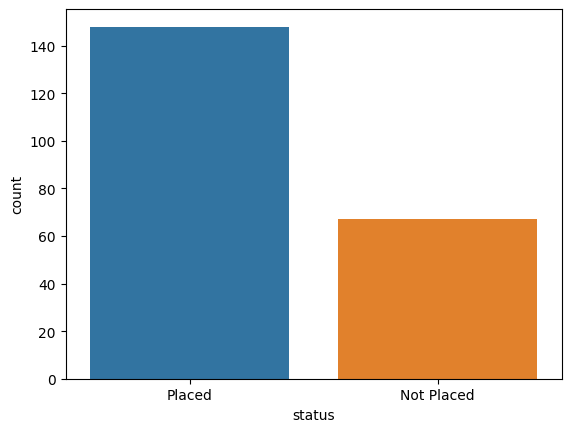

In [15]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [16]:
# shows numerical variables distribution
def num_summary(df, col, plot=False):
    quantiles = [0.05, 0.15, 0.25, 0.5, 0.75, 0.8, 0.95, 0.99]
    print(df[col].describe(quantiles).T)
    
    if plot:
        df[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()

count   215.00
mean     67.30
std      10.83
min      40.89
5%       49.70
15%      55.00
25%      60.60
50%      67.00
75%      75.70
80%      77.00
95%      84.20
99%      87.00
max      89.40
Name: 10th_grade, dtype: float64


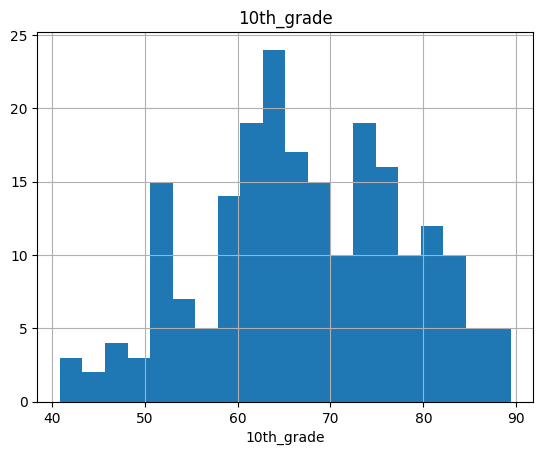

count   215.00
mean     66.33
std      10.90
min      37.00
5%       48.40
15%      57.00
25%      60.90
50%      65.00
75%      73.00
80%      74.73
95%      87.00
99%      91.86
max      97.70
Name: 12nd_grade, dtype: float64


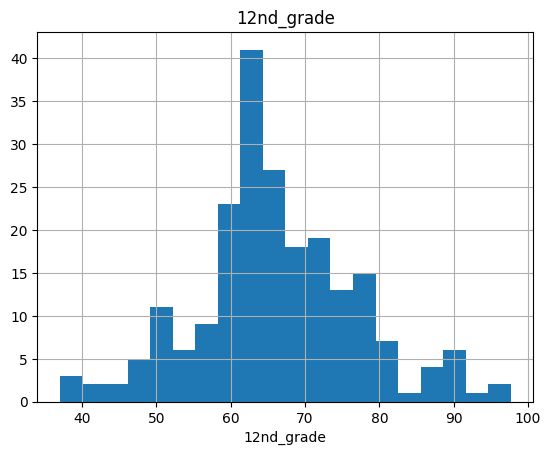

count   215.00
mean     66.37
std       7.36
min      50.00
5%       54.81
15%      58.00
25%      61.00
50%      66.00
75%      72.00
80%      72.13
95%      78.47
99%      83.86
max      91.00
Name: degree_p, dtype: float64


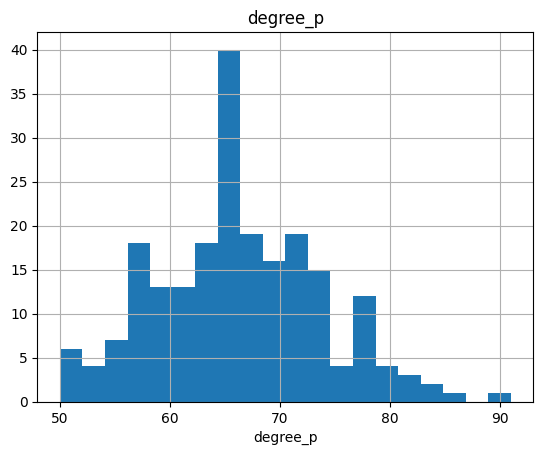

count   215.00
mean     72.10
std      13.28
min      50.00
5%       54.34
15%      57.60
25%      60.00
50%      71.00
75%      83.50
80%      86.00
95%      95.00
99%      97.00
max      98.00
Name: employability_t, dtype: float64


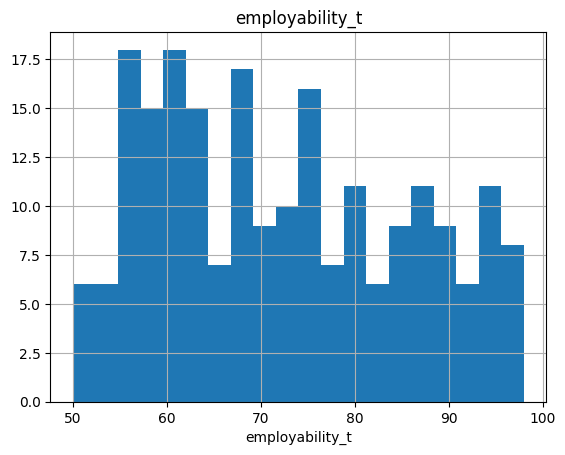

count   215.00
mean     62.28
std       5.83
min      51.21
5%       53.26
15%      56.17
25%      57.95
50%      62.00
75%      66.25
80%      67.14
95%      72.19
99%      76.11
max      77.89
Name: mba_p, dtype: float64


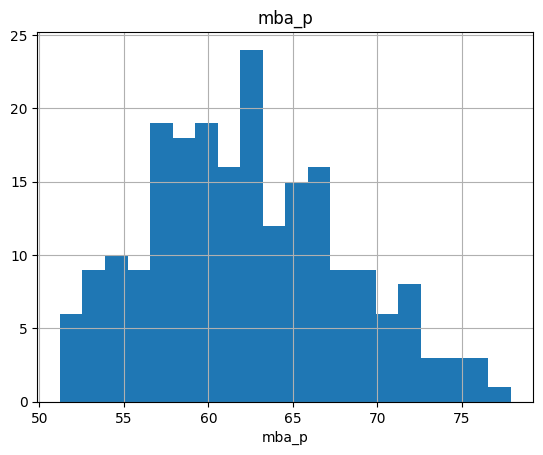

count      148.00
mean    288655.41
std      93457.45
min     200000.00
5%      206100.00
15%     225250.00
25%     240000.00
50%     265000.00
75%     300000.00
80%     300000.00
95%     423250.00
99%     671200.00
max     940000.00
Name: salary, dtype: float64


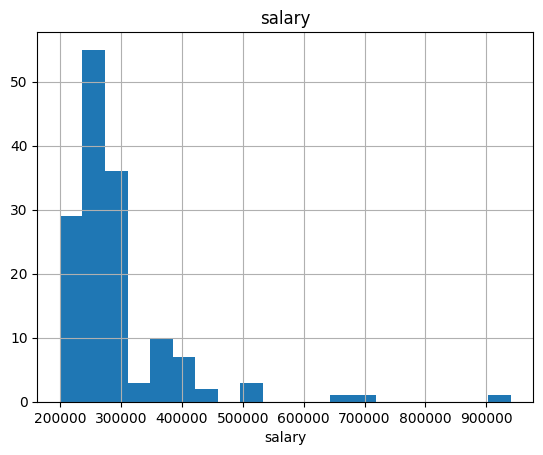

In [17]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [18]:
df[num_cols].corr()

,10th_grade,12nd_grade,degree_p,employability_t,mba_p,salary
10th_grade,1.00,0.51,0.54,0.26,0.39,0.04
12nd_grade,0.51,1.00,0.43,0.25,0.35,0.08
degree_p,0.54,0.43,1.00,0.22,0.40,-0.02
employability_t,0.26,0.25,0.22,1.00,0.22,0.18
mba_p,0.39,0.35,0.40,0.22,1.00,0.18
salary,0.04,0.08,-0.02,0.18,0.18,1.00


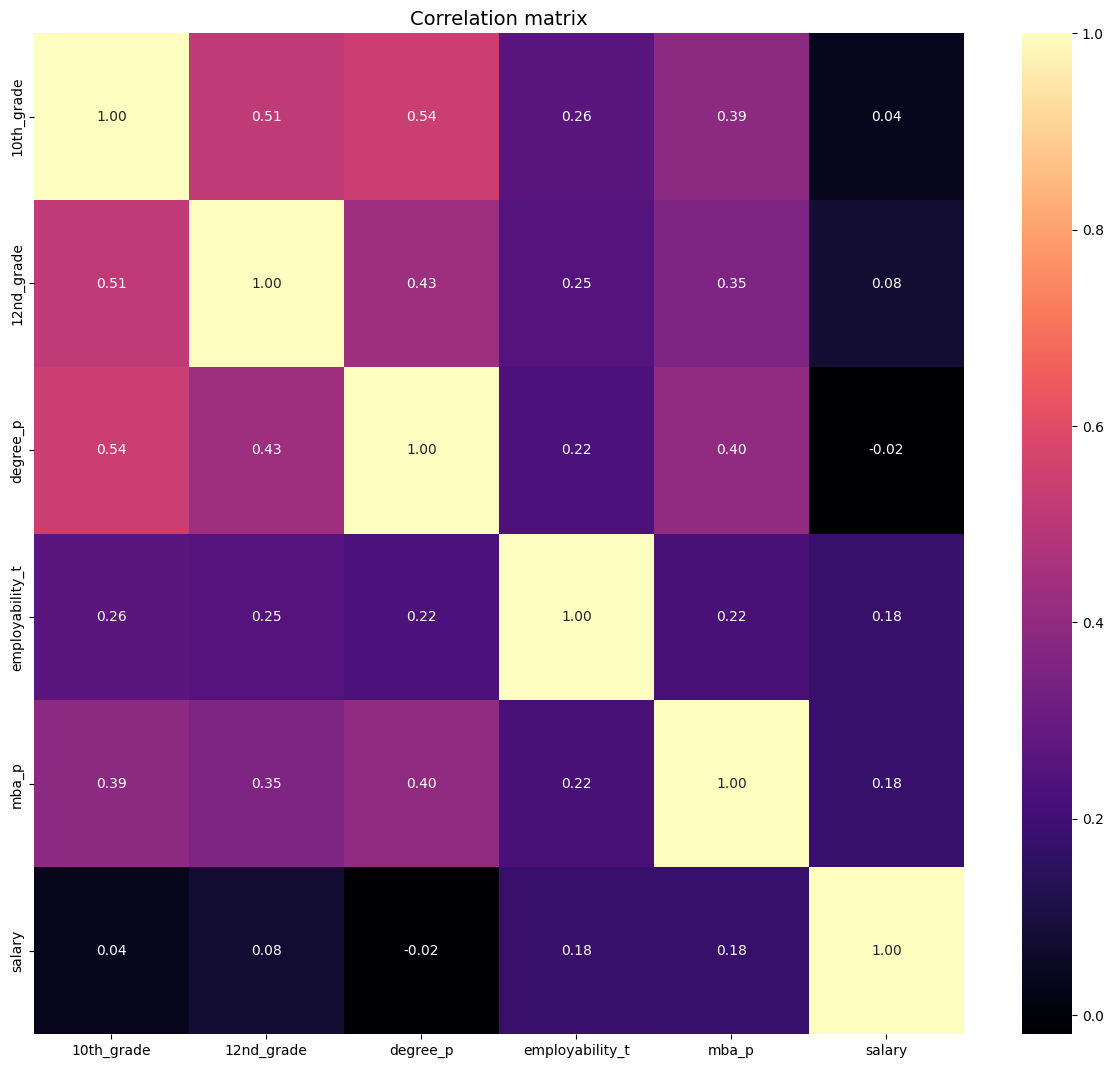

In [19]:
# corr matrix represent correlation between multiple variables
f, ax = plt.subplots(figsize=[15,13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="magma")
ax.set_title("Correlation matrix", fontsize=14)
plt.show()

In [20]:
# the function is useful for identifying columns in a DataFrame that have missing values
def missing_values_table(df, na_name=False):
    na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_cols].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n\n")
    if na_name:
        return na_cols

In [21]:
na_cols = missing_values_table(df, na_name=True)

        n_miss  ratio
salary      67  31.16



In [22]:
# handiling missing values in salary
df["salary"] = df["salary"].fillna(df.groupby("higher_edu_field")["salary"].transform("median"))

In [23]:
na_cols = missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []



In [24]:
df.isnull().sum()

gender              0
10th_grade          0
board_of_edu10      0
12nd_grade          0
board_of_edu12      0
higher_edu_field    0
degree_p            0
field_of_edu        0
workex              0
employability_t     0
specialisation      0
mba_p               0
status              0
salary              0
dtype: int64

In [25]:
dff = df.copy()

In [26]:
# calculate the lower and upper limits
def outlier_thresholds(df, col, q1=0.01, q3=0.95):
    quantile1 = df[col].quantile(q1)
    quantile3 = df[col].quantile(q3)
    iqr = q3 - q1
    low_limit = quantile1 - 1.5 * iqr
    up_limit = quantile3 - 1.5 * iqr
    return low_limit, up_limit

In [27]:
# check the columns if it has outliers or not
def check_outlier(df, col):
    low_limit, up_limit = outlier_thresholds(df, col)
    if df[((df[col] > up_limit )| (df[col] < low_limit))].any(axis=None):
        return True
    else:
        return False

In [28]:
# replace thresholds with lower and upper limit values
def replace_with_thresholds(df, col, q1=0.01, q3=0.95):
    low_limit, up_limit = outlier_thresholds(df, col)
    df.loc[(df[col] > up_limit), col] = up_limit
    df.loc[(df[col] < low_limit), col] = low_limit

In [29]:
for col in num_cols:
    print(col, check_outlier(dff, col))
    if check_outlier(dff, col):
        replace_with_thresholds(dff, col)

10th_grade True
12nd_grade True
degree_p True
employability_t True
mba_p True
salary True


In [30]:
dff.head()

,gender,10th_grade,board_of_edu10,12nd_grade,board_of_edu12,higher_edu_field,degree_p,field_of_edu,workex,employability_t,specialisation,mba_p,status,salary
0,M,67.00,Others,85.59,Others,Commerce,58.00,Sci&Tech,No,55.00,Mkt&HR,58.80,Placed,270000.00
1,M,79.33,Central,78.33,Others,Science,77.06,Sci&Tech,Yes,86.50,Mkt&Fin,66.28,Placed,200000.00
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.00,Mkt&Fin,57.80,Placed,250000.00
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.00,Mkt&HR,59.43,Not Placed,260000.00
4,M,82.79,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,93.59,Mkt&Fin,55.50,Placed,399998.59


## Feature engineering

In [31]:
# feature extraction
dff["10th_grade*12nd_grade"] = dff["10th_grade"] * dff["12nd_grade"]
dff["degree_p*mba_p"] = dff["degree_p"] * df["mba_p"]

In [32]:
dff["salary"].describe()

count      215.00
mean    273092.93
std      47554.75
min     200000.00
25%     250000.00
50%     265000.00
75%     282500.00
max     399998.59
Name: salary, dtype: float64

In [33]:
# categorizing salary amd degree_p

In [34]:
dff.loc[(dff["salary"] <= 250000), "salary_cat"] = "low"
dff.loc[(dff["salary"] > 250000) & (dff["salary"] <= 300000), "salary_cat"] = "moderate"
dff.loc[(dff["salary"] > 300000) & (dff["salary"] <= 350000), "salary_cat"] = "high"
dff.loc[(dff["salary"] > 350000), "salary_cat"] = "very high"

In [35]:
dff["degree_p"].describe()

count   215.00
mean     66.08
std       6.77
min      50.00
25%      61.00
50%      66.00
75%      72.00
max      77.06
Name: degree_p, dtype: float64

In [36]:
bins = [0, 60, 70, 80, 90, 100]
labels = ["Low", "Average", "Good", "Very Good", "Excellent"]

dff["degree_p_cat"] = pd.cut(dff["degree_p"], bins=bins, labels=labels)

In [37]:
dff.head()

,gender,10th_grade,board_of_edu10,12nd_grade,board_of_edu12,higher_edu_field,degree_p,field_of_edu,workex,employability_t,specialisation,mba_p,status,salary,10th_grade*12nd_grade,degree_p*mba_p,salary_cat,degree_p_cat
0,M,67.00,Others,85.59,Others,Commerce,58.00,Sci&Tech,No,55.00,Mkt&HR,58.80,Placed,270000.00,5734.53,3410.40,moderate,Low
1,M,79.33,Central,78.33,Others,Science,77.06,Sci&Tech,Yes,86.50,Mkt&Fin,66.28,Placed,200000.00,6213.92,5107.40,low,Good
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.00,Mkt&Fin,57.80,Placed,250000.00,4420.00,3699.20,low,Average
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.00,Mkt&HR,59.43,Not Placed,260000.00,2912.00,3090.36,moderate,Low
4,M,82.79,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,93.59,Mkt&Fin,55.50,Placed,399998.59,6093.34,4068.15,very high,Good


In [38]:
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations : 215

Variables : 18

cat_cols : ['gender', 'board_of_edu10', 'board_of_edu12', 'higher_edu_field', 'field_of_edu', 'workex', 'specialisation', 'status', 'salary_cat', 'degree_p_cat']

num_cols : ['10th_grade', '12nd_grade', 'degree_p', 'employability_t', 'mba_p', 'salary', '10th_grade*12nd_grade', 'degree_p*mba_p']

cat_but_car : []

num_but_car: ['degree_p_cat']



In [39]:
cat_cols = [col for col in cat_cols if col not in ["status"]]

In [40]:
# convert categorical variables into binary columns
def one_hot_encoder(df, cat_cols, drop_first=False):
    df = pd.get_dummies(df, columns=cat_cols, drop_first=drop_first)
    return df

In [41]:
dff = one_hot_encoder(dff, cat_cols, drop_first=True)
dff.head()

,10th_grade,12nd_grade,degree_p,employability_t,mba_p,status,salary,10th_grade*12nd_grade,degree_p*mba_p,gender_M,board_of_edu10_Others,board_of_edu12_Others,higher_edu_field_Commerce,higher_edu_field_Science,field_of_edu_Others,field_of_edu_Sci&Tech,workex_Yes,specialisation_Mkt&HR,salary_cat_low,salary_cat_moderate,salary_cat_very high,degree_p_cat_Average,degree_p_cat_Good,degree_p_cat_Very Good,degree_p_cat_Excellent
0,67.00,85.59,58.00,55.00,58.80,Placed,270000.00,5734.53,3410.40,1,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0
1,79.33,78.33,77.06,86.50,66.28,Placed,200000.00,6213.92,5107.40,1,0,1,0,1,0,1,1,0,1,0,0,0,1,0,0
2,65.00,68.00,64.00,75.00,57.80,Placed,250000.00,4420.00,3699.20,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,56.00,52.00,52.00,66.00,59.43,Not Placed,260000.00,2912.00,3090.36,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0
4,82.79,73.60,73.30,93.59,55.50,Placed,399998.59,6093.34,4068.15,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0


In [42]:
check_df(dff)

### HEAD ###
   10th_grade  12nd_grade  degree_p  employability_t  mba_p      status    salary  10th_grade*12nd_grade  degree_p*mba_p  gender_M  board_of_edu10_Others  board_of_edu12_Others  \
0       67.00       85.59     58.00            55.00  58.80      Placed 270000.00                5734.53         3410.40         1                      1                      1   
1       79.33       78.33     77.06            86.50  66.28      Placed 200000.00                6213.92         5107.40         1                      0                      1   
2       65.00       68.00     64.00            75.00  57.80      Placed 250000.00                4420.00         3699.20         1                      0                      0   
3       56.00       52.00     52.00            66.00  59.43  Not Placed 260000.00                2912.00         3090.36         1                      0                      0   
4       82.79       73.60     73.30            93.59  55.50      Placed 399998.59      

In [43]:
binary_cols = [col for col in dff.columns if dff[col].nunique() == 2 and dff[col].dtypes == "O" and col not in ["status"]]
binary_cols

[]

In [44]:
# assigns a unique label to each category in the categorical variable
def label_encoder(df, binary_col):
    le = LabelEncoder()
    df[binary_col] = le.fit_transform(df[binary_col])
    return df

In [45]:
for col in binary_cols:
    label_encoder(dff, col)

In [46]:
dff.head()

,10th_grade,12nd_grade,degree_p,employability_t,mba_p,status,salary,10th_grade*12nd_grade,degree_p*mba_p,gender_M,board_of_edu10_Others,board_of_edu12_Others,higher_edu_field_Commerce,higher_edu_field_Science,field_of_edu_Others,field_of_edu_Sci&Tech,workex_Yes,specialisation_Mkt&HR,salary_cat_low,salary_cat_moderate,salary_cat_very high,degree_p_cat_Average,degree_p_cat_Good,degree_p_cat_Very Good,degree_p_cat_Excellent
0,67.00,85.59,58.00,55.00,58.80,Placed,270000.00,5734.53,3410.40,1,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0
1,79.33,78.33,77.06,86.50,66.28,Placed,200000.00,6213.92,5107.40,1,0,1,0,1,0,1,1,0,1,0,0,0,1,0,0
2,65.00,68.00,64.00,75.00,57.80,Placed,250000.00,4420.00,3699.20,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,56.00,52.00,52.00,66.00,59.43,Not Placed,260000.00,2912.00,3090.36,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0
4,82.79,73.60,73.30,93.59,55.50,Placed,399998.59,6093.34,4068.15,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0


In [47]:
num_cols

['10th_grade',
 '12nd_grade',
 'degree_p',
 'employability_t',
 'mba_p',
 'salary',
 '10th_grade*12nd_grade',
 'degree_p*mba_p']

In [48]:
# standartization for ml algorithms
scaler = StandardScaler()
dff[num_cols] = scaler.fit_transform(dff[num_cols])

In [49]:
dff.head()

,10th_grade,12nd_grade,degree_p,employability_t,mba_p,status,salary,10th_grade*12nd_grade,degree_p*mba_p,gender_M,board_of_edu10_Others,board_of_edu12_Others,higher_edu_field_Commerce,higher_edu_field_Science,field_of_edu_Others,field_of_edu_Sci&Tech,workex_Yes,specialisation_Mkt&HR,salary_cat_low,salary_cat_moderate,salary_cat_very high,degree_p_cat_Average,degree_p_cat_Good,degree_p_cat_Very Good,degree_p_cat_Excellent
0,-0.01,1.91,-1.20,-1.31,-0.60,Placed,-0.07,1.06,-1.06,1,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0
1,1.18,1.20,1.63,1.12,0.79,Placed,-1.54,1.47,1.44,1,0,1,0,1,0,1,1,0,1,0,0,0,1,0,0
2,-0.20,0.19,-0.31,0.24,-0.79,Placed,-0.49,-0.06,-0.63,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,-1.06,-1.38,-2.09,-0.46,-0.49,Not Placed,-0.28,-1.34,-1.53,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0
4,1.51,0.74,1.07,1.67,-1.22,Placed,2.67,1.36,-0.09,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0


## Machine Learning Models

In [50]:
y = dff["status"]
X = dff.drop(["status"], axis=1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
# model evaluation
def model_score(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"### {model_name} Classifier ###")
    print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
    print(f"Recall: {round(recall_score(y_test, y_pred, pos_label='Placed'), 3)}")
    print(f"Precision: {round(precision_score(y_test, y_pred, pos_label='Placed'), 2)}")
    print(f"F1: {round(f1_score(y_test, y_pred, pos_label='Placed'), 2)}")
    
    return model

In [53]:
# visualize the feature importance 
def plot_feature_importance(importance, names, model):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {"feature_name": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by="feature_importance", ascending=False, inplace=True)
    
    plt.figure(figsize=(15, 10))
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_name"])
    
    plt.title(f"{model} - Feature Importance")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Names")
    plt.show()

In [54]:
# random forest model
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [55]:
model = model_score(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

### Random Forest Classifier ###
Accuracy: 0.91
Recall: 0.975
Precision: 0.91
F1: 0.94


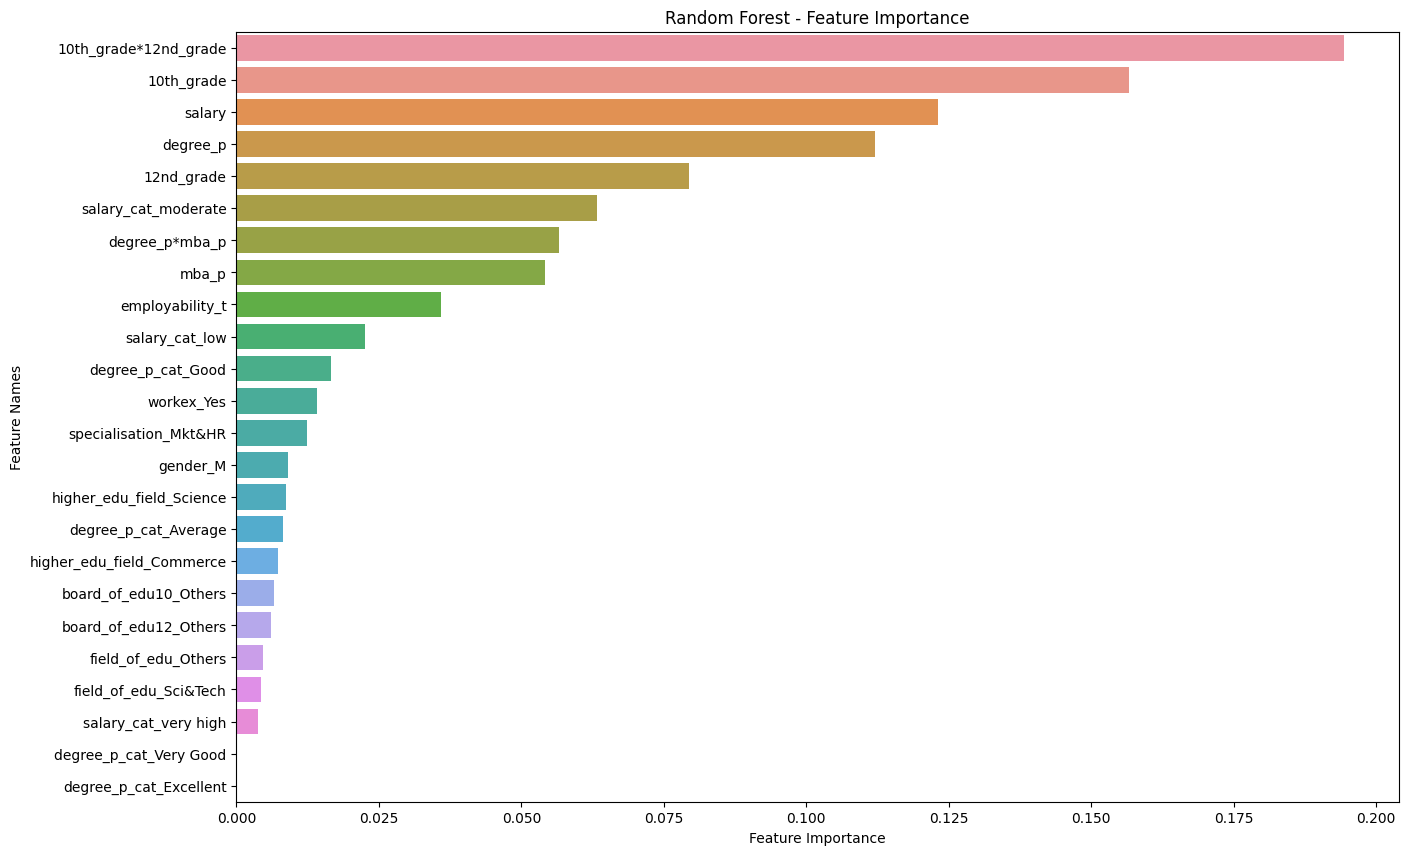

In [56]:
plot_feature_importance(rf_model.feature_importances_, X.columns, "Random Forest")

In [57]:
# catboost model
cb_model = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
y_pred = cb_model.predict(X_test)

In [58]:
model = model_score(cb_model, X_train, y_train, X_test, y_test, "CatBoost")

### CatBoost Classifier ###
Accuracy: 0.93
Recall: 0.975
Precision: 0.93
F1: 0.95


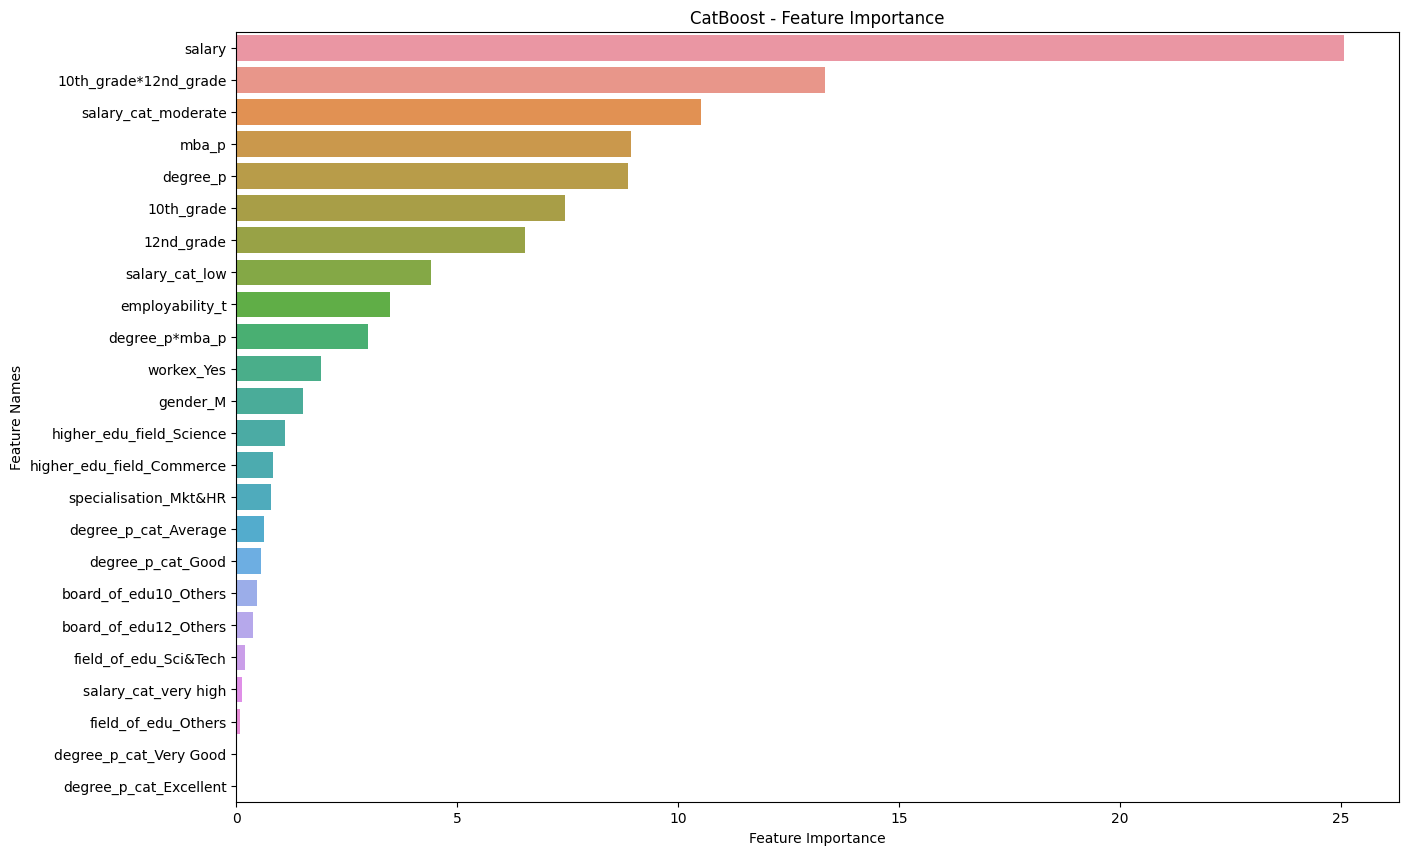

In [59]:
plot_feature_importance(cb_model.get_feature_importance(), X.columns, "CatBoost")

In [60]:
# svm model
svm_model = svm.SVC().fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [61]:
model = model_score(svm_model, X_train, y_train, X_test, y_test, "Support Vector Machine")

### Support Vector Machine Classifier ###
Accuracy: 0.91
Recall: 0.975
Precision: 0.91
F1: 0.94


## Deep Learning Model

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [63]:
le = LabelEncoder()
dff['status'] = le.fit_transform(dff['status'])

In [64]:
y = dff["status"]
X = dff.drop(["status"], axis=1)
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [66]:
class DeepLearningModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer3 = nn.Linear(in_features=hidden_size, out_features=num_classes)
        
    def forward(self, x):
         
        return self.layer3(self.layer2(self.layer1(x)))

In [67]:
class DeepLearningModel1(nn.Module):
    def __init__(self, input_feat, output_feat, hidden_layer):
            super().__init__()
            self.layer = nn.Sequential(
            nn.Linear(in_features=input_feat, out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer, out_features=hidden_layer),
            nn.ReLU())
        
    def forward(self, x):
        return self.layer(x)

In [68]:
def model_eval(model, X_test, y_test):
    model.eval()
    with torch.inference_mode():
        y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
    print(y_preds[:10], "\n",y_test[:10])

In [69]:
# parameters
input_size = X.shape[1]
hidden_layer = 16
num_classes = 1

In [70]:
# hiperparameters
lr = 0.01
epoch = 50
batchsize = 32

In [71]:
# model
model = DeepLearningModel(input_size, hidden_layer, num_classes).to(device)
model

DeepLearningModel(
  (layer1): Linear(in_features=24, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

In [72]:
model1 = DeepLearningModel1(input_size, hidden_layer, num_classes).to(device)
model1

DeepLearningModel1(
  (layer): Sequential(
    (0): Linear(in_features=24, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [73]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [74]:
loss_fn = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [75]:
torch.manual_seed(42)    
# model training
epochs = epoch
batch_size = batchsize

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #  Pass forward
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # Calculate the loss
    loss = loss_fn(y_logits, y_train)        
    acc = accuracy_fn(y_true=y_train, 
    y_pred=y_pred)

    #  Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    #  Optimizer step
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        #  Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate the loss
        test_loss = loss_fn(test_logits,
                                y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.67407, Accuracy: 63.98% | Test loss: 0.62471, Test acc: 72.22%
Epoch: 10 | Loss: 0.28781, Accuracy: 87.58% | Test loss: 0.40091, Test acc: 81.48%
Epoch: 20 | Loss: 0.17772, Accuracy: 91.93% | Test loss: 0.20760, Test acc: 87.04%
Epoch: 30 | Loss: 0.13753, Accuracy: 95.03% | Test loss: 0.13782, Test acc: 94.44%
Epoch: 40 | Loss: 0.12000, Accuracy: 95.03% | Test loss: 0.12656, Test acc: 94.44%


In [76]:
model_eval(model, X_test, y_test)

tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0') 
 tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')


In [77]:
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr = 0.01)

In [78]:
torch.manual_seed(42)
# model training
epochs = 50
batch_size = 32

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #  Pass forward
    y_logits = model1(X_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_probs)# logits -> predicition probabilities -> prediction labels
    
    # Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train.int()) 


    #  Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    #  Optimizer step
    optimizer.step()

    # Testing
    model1.eval()
    with torch.inference_mode():
        test_logits = model1(X_test).squeeze()
        test_pred_probs = torch.sigmoid(test_logits)
        test_pred = torch.round(test_pred_probs)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int())

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.68793, Accuracy: 0.40% | Test loss: 0.69166, Test acc: 0.30%
Epoch: 10 | Loss: 0.68691, Accuracy: 0.40% | Test loss: 0.69114, Test acc: 0.30%
Epoch: 20 | Loss: 0.68580, Accuracy: 0.41% | Test loss: 0.69059, Test acc: 0.30%
Epoch: 30 | Loss: 0.68431, Accuracy: 0.42% | Test loss: 0.68997, Test acc: 0.30%
Epoch: 40 | Loss: 0.68233, Accuracy: 0.42% | Test loss: 0.68891, Test acc: 0.33%


In [79]:
model_eval(model1, X_test, y_test)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0') 
 tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
